In [1]:
%matplotlib inline

import numpy as np
import sys
import os
import matplotlib.pyplot as plt
import math
import pickle
import pandas as pd
import scipy.io
import time
import h5py
import bz2
import multiprocessing as mp


from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable

from numpy import linalg as LA
from scipy.spatial import Delaunay
from sklearn.neighbors import NearestNeighbors, KDTree

from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import matthews_corrcoef

#sys.path.insert(0, "../")
from info3d import *
from nn_matchers import *

# Extracting the point collection and the descriptors

In [20]:
"""with open('point_collection/new_contiguous_point_collection.pickle','rb') as f: 
    new_contiguous_point_collection = pickle.load(f)
    
with open('descriptors/new_complete_res5_4by5_descriptors.pickle','rb') as f:
    descriptors = pickle.load(f)
    
with open('descriptors/new_complete_RANSAC_res5_4by5_descriptors.pickle','rb') as f:
    ransac_descriptors = pickle.load(f)
"""
with open('../../spatial-privacy/descriptors/chosen_arcore_res5_4by5_descriptors_complete.pickle','rb') as f:
    arcore_descriptors = pickle.load(f)

RESULTS_FOLDER="testing_results/nn_matcher_arcore/"
if not os.path.exists(RESULTS_FOLDER): os.mkdir(RESULTS_FOLDER)   

In [21]:

with open('../../spatial-privacy/point_collection/2_filled_quaternion_vertical_correction_arcore_point_cloud_collection_complete.pickle','rb') as f: 
    arcore_point_cloud_collection = pickle.load(f)
    
with open('sample_arcore_points.pickle','rb') as f:
    sample_arcore_points = pickle.load(f)
    
arcore_spaces = [[],[],[],[],[],[],[]]
    
for [obj_num, name, timestamp], t_pointCloud, triangles in arcore_point_cloud_collection:
    
    unique_normals = np.unique(np.around(t_pointCloud[:,3:],decimals = 2),axis = 0)
    
    #print(obj_num, name, timestamp, len(unique_normals))
    try:
        arcore_spaces[int(obj_num)].append([
            [obj_num, name, timestamp],
            t_pointCloud, 
            triangles,
            len(unique_normals)
        ])
    except:
        continue
        

chosen_arcore_spaces = []

for space in arcore_spaces:
    
    per_space_values = []
    
    per_sample_most_planes = 0
    max_num_normals = 0

    for i_s, [[obj_num, obj_name, timestamp] , t_pointCloud, triangles, num_normals] in enumerate(space):

        if num_normals > max_num_normals: 
            max_num_normals = num_normals
            per_sample_most_planes = i_s
            
    print(obj_num,obj_name,": chosen", per_sample_most_planes, "with",max_num_normals,"planes",timestamp)
            
    chosen_arcore_spaces.append(space[per_sample_most_planes])
    
len(arcore_spaces),len(chosen_arcore_spaces)


0 reception : chosen 3 with 5 planes 2020.01.14.12.17.08
1 driveway : chosen 4 with 8 planes 2020.02.17.09.52.08
2 apartment : chosen 2 with 8 planes 2020.02.17.09.45.56
3 workstation : chosen 4 with 4 planes 2020.01.14.11.21.11
4 kitchen : chosen 2 with 4 planes 2020.01.14.14.06.43
5 hallway : chosen 0 with 3 planes 2020.01.14.12.08.32
6 stairwell : chosen 0 with 2 planes 2020.01.14.14.20.59


(7, 7)

# Step 1.2: ARcore spaces validation

In [25]:
descriptors = arcore_descriptors[:-1]

partial_results_path = os.path.join(RESULTS_FOLDER,"partial")

if not os.path.exists(partial_results_path): os.mkdir(partial_results_path)
    
exp_eval_propeties = []

for radius in np.arange(0.25,5.1,0.25):
    
    t0 = time.time()
    t1 = time.time()
    
    partial_scores_pool = []
    per_radius_properties = []
    
    print("radius =",radius)
    
    for obj_, obj_sample, object_name, original_vertex in sample_arcore_points:
    #for s_i in sample_points_300:
        
        t3 = time.time()
        
        #obj_, object_name, original_vertex = sample_points[s_i]
        
        pointCloud = []
        
        try:
            object_, ransac_pointCloud, tri_, u_n_ = arcore_spaces[obj_][obj_sample]
            
            ransac_nbrs = NearestNeighbors(n_neighbors=min(20000,len(ransac_pointCloud)), algorithm='kd_tree').fit(ransac_pointCloud[:,:3])
            
            dist_, ind_ = ransac_nbrs.kneighbors([original_vertex[:3]])
            pointCloud =  ransac_pointCloud[ind_[0,np.where(dist_[0,:]<=radius)[0]]]
            
        except:
            print("Can't get ransac samples for",trial,obj_meta[0],dist_.shape,ind_.shape)
            continue
            
        #if len(gen_planes) == 0: continue
        if len(pointCloud) == 0: continue

        local_keypoint_matches = []

        try:
            obj_meta, diff_ratios, diff_indexs, diff_scores, local_keypoint_matches = get_score_kdtree_lean(
                [obj_, object_name, original_vertex], 
                pointCloud, 
                descriptors,
                desc_new=True,
                old=True
                #key_cap=keypoint_cap,
                #strict_cap=True
            )
            
        except Exception as ex:
            print(ex)
            print("skipped",object_name)
            continue
        
        if len(local_keypoint_matches) == 0: 
            print("skipped",object_name)
            continue

        t4 = time.time()

        partial_scores_pool.append([
            [obj_, object_name, original_vertex], 
            diff_ratios,
            diff_indexs,
            diff_scores,
            local_keypoint_matches
        ])
                
        per_radius_properties.append([
            diff_ratios.shape,
            diff_indexs.shape,
            diff_scores.shape,
            t4 - t3
        ])

        if len(partial_scores_pool) % 66 == 2:
            
            partial_errors_pool = ARcore_NNMatcher(partial_scores_pool, descriptors)
            print("  ",radius,": Done with {}, in {:.3f} seconds. Error rate {:.3f}".format(
                len(partial_scores_pool),
                time.time()-t1,
                np.sum(partial_errors_pool[:,1])/len(partial_scores_pool)
            ))
            print("  ",
                  diff_ratios.shape,
                  diff_indexs.shape,
                  diff_scores.shape,
                  "in {:.3f} seconds".format(t4 - t3)
                 )
                        
            with bz2.BZ2File(RESULTS_FOLDER+'{}_partial_scores.pickle.bz2'.format(radius), 'w') as bz2_f:
                pickle.dump(partial_scores_pool, bz2_f)
                
            t1  = time.time()
            
    exp_eval_propeties.append([
        radius,
        per_radius_properties
    ])
    
    with open(RESULTS_FOLDER+'eval_properties.pickle', 'wb') as f:
        pickle.dump(exp_eval_propeties, f)

    print(radius," Total Time to match {:.3f} seconds.".format(time.time()-t0))
    
    #print(len(partial_lengths))
       

radius = 0.25
   0.25 : Done with 2, in 0.094 seconds. Error rate 0.500
   (8, 7) (8, 7, 2) (8, 7, 2) in 0.048 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:690: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  if i_o != np.argmax(weighted_scores): #!= i_o:
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: Mean of empty slice
/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:690: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  if i_o != np.argmax(weighted_scores): #!= i_o:
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: Mean of empty slice


   0.25 : Done with 68, in 2.864 seconds. Error rate 0.868
   (8, 7) (8, 7, 2) (8, 7, 2) in 0.049 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:690: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  if i_o != np.argmax(weighted_scores): #!= i_o:
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: Mean of empty slice


   0.25 : Done with 134, in 2.912 seconds. Error rate 0.843
   (9, 7) (9, 7, 2) (9, 7, 2) in 0.065 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:690: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  if i_o != np.argmax(weighted_scores): #!= i_o:
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: Mean of empty slice


   0.25 : Done with 200, in 2.937 seconds. Error rate 0.850
   (9, 7) (9, 7, 2) (9, 7, 2) in 0.051 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:690: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  if i_o != np.argmax(weighted_scores): #!= i_o:
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: Mean of empty slice


   0.25 : Done with 266, in 3.062 seconds. Error rate 0.853
   (10, 7) (10, 7, 2) (10, 7, 2) in 0.035 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:690: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  if i_o != np.argmax(weighted_scores): #!= i_o:
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: Mean of empty slice


   0.25 : Done with 332, in 2.826 seconds. Error rate 0.846
   (8, 7) (8, 7, 2) (8, 7, 2) in 0.034 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:690: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  if i_o != np.argmax(weighted_scores): #!= i_o:
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: Mean of empty slice


   0.25 : Done with 398, in 2.861 seconds. Error rate 0.837
   (9, 7) (9, 7, 2) (9, 7, 2) in 0.037 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:690: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  if i_o != np.argmax(weighted_scores): #!= i_o:
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: Mean of empty slice


   0.25 : Done with 464, in 3.176 seconds. Error rate 0.845
   (8, 7) (8, 7, 2) (8, 7, 2) in 0.045 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:690: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  if i_o != np.argmax(weighted_scores): #!= i_o:
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: Mean of empty slice


   0.25 : Done with 530, in 3.101 seconds. Error rate 0.845
   (7, 7) (7, 7, 2) (7, 7, 2) in 0.050 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:690: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  if i_o != np.argmax(weighted_scores): #!= i_o:
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: Mean of empty slice


   0.25 : Done with 596, in 3.226 seconds. Error rate 0.849
   (9, 7) (9, 7, 2) (9, 7, 2) in 0.037 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:690: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  if i_o != np.argmax(weighted_scores): #!= i_o:
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: Mean of empty slice


   0.25 : Done with 662, in 3.023 seconds. Error rate 0.840
   (12, 7) (12, 7, 2) (12, 7, 2) in 0.038 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:690: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  if i_o != np.argmax(weighted_scores): #!= i_o:
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: Mean of empty slice


   0.25 : Done with 728, in 3.175 seconds. Error rate 0.845
   (8, 7) (8, 7, 2) (8, 7, 2) in 0.047 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:690: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  if i_o != np.argmax(weighted_scores): #!= i_o:
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: Mean of empty slice


   0.25 : Done with 794, in 3.267 seconds. Error rate 0.843
   (8, 7) (8, 7, 2) (8, 7, 2) in 0.047 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:690: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  if i_o != np.argmax(weighted_scores): #!= i_o:
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: Mean of empty slice


   0.25 : Done with 860, in 3.310 seconds. Error rate 0.847
   (7, 7) (7, 7, 2) (7, 7, 2) in 0.061 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:690: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  if i_o != np.argmax(weighted_scores): #!= i_o:
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: Mean of empty slice


   0.25 : Done with 926, in 3.419 seconds. Error rate 0.851
   (11, 7) (11, 7, 2) (11, 7, 2) in 0.052 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:690: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  if i_o != np.argmax(weighted_scores): #!= i_o:
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: Mean of empty slice


   0.25 : Done with 992, in 3.373 seconds. Error rate 0.850
   (6, 7) (6, 7, 2) (6, 7, 2) in 0.038 seconds
0.25  Total Time to match 55.388 seconds.
radius = 0.5
   0.5 : Done with 2, in 0.120 seconds. Error rate 1.000
   (22, 7) (22, 7, 2) (22, 7, 2) in 0.054 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:690: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  if i_o != np.argmax(weighted_scores): #!= i_o:


   0.5 : Done with 68, in 4.076 seconds. Error rate 0.868
   (17, 7) (17, 7, 2) (17, 7, 2) in 0.056 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:690: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  if i_o != np.argmax(weighted_scores): #!= i_o:


   0.5 : Done with 134, in 4.241 seconds. Error rate 0.896
   (31, 7) (31, 7, 2) (31, 7, 2) in 0.092 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:690: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  if i_o != np.argmax(weighted_scores): #!= i_o:
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: Mean of empty slice


   0.5 : Done with 200, in 4.102 seconds. Error rate 0.855
   (29, 7) (29, 7, 2) (29, 7, 2) in 0.072 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:690: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  if i_o != np.argmax(weighted_scores): #!= i_o:
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: Mean of empty slice


   0.5 : Done with 266, in 4.089 seconds. Error rate 0.838
   (26, 7) (26, 7, 2) (26, 7, 2) in 0.057 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:690: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  if i_o != np.argmax(weighted_scores): #!= i_o:
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: Mean of empty slice


   0.5 : Done with 332, in 4.630 seconds. Error rate 0.849
   (25, 7) (25, 7, 2) (25, 7, 2) in 0.058 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:690: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  if i_o != np.argmax(weighted_scores): #!= i_o:
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: Mean of empty slice


   0.5 : Done with 398, in 4.789 seconds. Error rate 0.837
   (34, 7) (34, 7, 2) (34, 7, 2) in 0.074 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:690: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  if i_o != np.argmax(weighted_scores): #!= i_o:
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: Mean of empty slice


   0.5 : Done with 464, in 5.204 seconds. Error rate 0.849
   (26, 7) (26, 7, 2) (26, 7, 2) in 0.069 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:690: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  if i_o != np.argmax(weighted_scores): #!= i_o:
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: Mean of empty slice


   0.5 : Done with 530, in 4.932 seconds. Error rate 0.851
   (25, 7) (25, 7, 2) (25, 7, 2) in 0.071 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:690: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  if i_o != np.argmax(weighted_scores): #!= i_o:
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: Mean of empty slice


   0.5 : Done with 596, in 4.305 seconds. Error rate 0.854
   (27, 7) (27, 7, 2) (27, 7, 2) in 0.054 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:690: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  if i_o != np.argmax(weighted_scores): #!= i_o:
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: Mean of empty slice


   0.5 : Done with 662, in 4.360 seconds. Error rate 0.855
   (31, 7) (31, 7, 2) (31, 7, 2) in 0.059 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:690: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  if i_o != np.argmax(weighted_scores): #!= i_o:
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: Mean of empty slice


   0.5 : Done with 728, in 4.506 seconds. Error rate 0.864
   (26, 7) (26, 7, 2) (26, 7, 2) in 0.066 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:690: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  if i_o != np.argmax(weighted_scores): #!= i_o:
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: Mean of empty slice


   0.5 : Done with 794, in 4.285 seconds. Error rate 0.864
   (26, 7) (26, 7, 2) (26, 7, 2) in 0.073 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:690: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  if i_o != np.argmax(weighted_scores): #!= i_o:
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: Mean of empty slice


   0.5 : Done with 860, in 4.606 seconds. Error rate 0.864
   (20, 7) (20, 7, 2) (20, 7, 2) in 0.052 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:690: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  if i_o != np.argmax(weighted_scores): #!= i_o:
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: Mean of empty slice


   0.5 : Done with 926, in 4.413 seconds. Error rate 0.861
   (29, 7) (29, 7, 2) (29, 7, 2) in 0.068 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:690: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  if i_o != np.argmax(weighted_scores): #!= i_o:
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: Mean of empty slice


   0.5 : Done with 992, in 4.526 seconds. Error rate 0.860
   (25, 7) (25, 7, 2) (25, 7, 2) in 0.054 seconds
0.5  Total Time to match 83.971 seconds.
radius = 0.75
   0.75 : Done with 2, in 0.190 seconds. Error rate 1.000
   (49, 7) (49, 7, 2) (49, 7, 2) in 0.086 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:690: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  if i_o != np.argmax(weighted_scores): #!= i_o:


   0.75 : Done with 68, in 6.380 seconds. Error rate 0.882
   (41, 7) (41, 7, 2) (41, 7, 2) in 0.075 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:690: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  if i_o != np.argmax(weighted_scores): #!= i_o:


   0.75 : Done with 134, in 6.638 seconds. Error rate 0.858
   (57, 7) (57, 7, 2) (57, 7, 2) in 0.155 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:690: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  if i_o != np.argmax(weighted_scores): #!= i_o:


   0.75 : Done with 200, in 6.468 seconds. Error rate 0.830
   (70, 7) (70, 7, 2) (70, 7, 2) in 0.128 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:690: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  if i_o != np.argmax(weighted_scores): #!= i_o:


   0.75 : Done with 266, in 6.729 seconds. Error rate 0.846
   (63, 7) (63, 7, 2) (63, 7, 2) in 0.107 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:690: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  if i_o != np.argmax(weighted_scores): #!= i_o:


   0.75 : Done with 332, in 6.542 seconds. Error rate 0.861
   (49, 7) (49, 7, 2) (49, 7, 2) in 0.080 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:690: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  if i_o != np.argmax(weighted_scores): #!= i_o:


   0.75 : Done with 398, in 6.615 seconds. Error rate 0.857
   (53, 7) (53, 7, 2) (53, 7, 2) in 0.092 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:690: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  if i_o != np.argmax(weighted_scores): #!= i_o:
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: Mean of empty slice


   0.75 : Done with 464, in 7.153 seconds. Error rate 0.849
   (61, 7) (61, 7, 2) (61, 7, 2) in 0.102 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:690: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  if i_o != np.argmax(weighted_scores): #!= i_o:
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: Mean of empty slice


   0.75 : Done with 530, in 7.136 seconds. Error rate 0.853
   (39, 7) (39, 7, 2) (39, 7, 2) in 0.078 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:690: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  if i_o != np.argmax(weighted_scores): #!= i_o:
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: Mean of empty slice


   0.75 : Done with 596, in 6.975 seconds. Error rate 0.857
   (50, 7) (50, 7, 2) (50, 7, 2) in 0.080 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:690: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  if i_o != np.argmax(weighted_scores): #!= i_o:
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: Mean of empty slice


   0.75 : Done with 662, in 6.766 seconds. Error rate 0.858
   (50, 7) (50, 7, 2) (50, 7, 2) in 0.086 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:690: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  if i_o != np.argmax(weighted_scores): #!= i_o:
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: Mean of empty slice


   0.75 : Done with 728, in 7.259 seconds. Error rate 0.853
   (49, 7) (49, 7, 2) (49, 7, 2) in 0.098 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:690: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  if i_o != np.argmax(weighted_scores): #!= i_o:
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: Mean of empty slice


   0.75 : Done with 794, in 7.075 seconds. Error rate 0.843
   (65, 7) (65, 7, 2) (65, 7, 2) in 0.144 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:690: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  if i_o != np.argmax(weighted_scores): #!= i_o:
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: Mean of empty slice


   0.75 : Done with 860, in 7.260 seconds. Error rate 0.842
   (26, 7) (26, 7, 2) (26, 7, 2) in 0.065 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:690: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  if i_o != np.argmax(weighted_scores): #!= i_o:
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: Mean of empty slice


   0.75 : Done with 926, in 7.404 seconds. Error rate 0.840
   (62, 7) (62, 7, 2) (62, 7, 2) in 0.130 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:690: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  if i_o != np.argmax(weighted_scores): #!= i_o:
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: Mean of empty slice


   0.75 : Done with 992, in 7.386 seconds. Error rate 0.840
   (37, 7) (37, 7, 2) (37, 7, 2) in 0.076 seconds
0.75  Total Time to match 132.530 seconds.
radius = 1.0
   1.0 : Done with 2, in 0.321 seconds. Error rate 1.000
   (88, 7) (88, 7, 2) (88, 7, 2) in 0.145 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:690: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  if i_o != np.argmax(weighted_scores): #!= i_o:


   1.0 : Done with 68, in 10.275 seconds. Error rate 0.779
   (61, 7) (61, 7, 2) (61, 7, 2) in 0.116 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:690: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  if i_o != np.argmax(weighted_scores): #!= i_o:


   1.0 : Done with 134, in 11.279 seconds. Error rate 0.799
   (122, 7) (122, 7, 2) (122, 7, 2) in 0.320 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:690: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  if i_o != np.argmax(weighted_scores): #!= i_o:


   1.0 : Done with 200, in 10.935 seconds. Error rate 0.805
   (92, 7) (92, 7, 2) (92, 7, 2) in 0.199 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:690: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  if i_o != np.argmax(weighted_scores): #!= i_o:


   1.0 : Done with 266, in 11.791 seconds. Error rate 0.823
   (107, 7) (107, 7, 2) (107, 7, 2) in 0.214 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:690: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  if i_o != np.argmax(weighted_scores): #!= i_o:


   1.0 : Done with 332, in 11.565 seconds. Error rate 0.828
   (84, 7) (84, 7, 2) (84, 7, 2) in 0.146 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:690: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  if i_o != np.argmax(weighted_scores): #!= i_o:


   1.0 : Done with 398, in 11.179 seconds. Error rate 0.829
   (87, 7) (87, 7, 2) (87, 7, 2) in 0.160 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:690: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  if i_o != np.argmax(weighted_scores): #!= i_o:


   1.0 : Done with 464, in 12.028 seconds. Error rate 0.836
   (90, 7) (90, 7, 2) (90, 7, 2) in 0.173 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:690: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  if i_o != np.argmax(weighted_scores): #!= i_o:


   1.0 : Done with 530, in 12.353 seconds. Error rate 0.838
   (86, 7) (86, 7, 2) (86, 7, 2) in 0.156 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:690: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  if i_o != np.argmax(weighted_scores): #!= i_o:


   1.0 : Done with 596, in 11.658 seconds. Error rate 0.844
   (66, 7) (66, 7, 2) (66, 7, 2) in 0.111 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:690: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  if i_o != np.argmax(weighted_scores): #!= i_o:


   1.0 : Done with 662, in 11.725 seconds. Error rate 0.846
   (87, 7) (87, 7, 2) (87, 7, 2) in 0.153 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:690: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  if i_o != np.argmax(weighted_scores): #!= i_o:


   1.0 : Done with 728, in 11.616 seconds. Error rate 0.853
   (89, 7) (89, 7, 2) (89, 7, 2) in 0.163 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:690: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  if i_o != np.argmax(weighted_scores): #!= i_o:


   1.0 : Done with 794, in 11.184 seconds. Error rate 0.848
   (93, 7) (93, 7, 2) (93, 7, 2) in 0.203 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:690: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  if i_o != np.argmax(weighted_scores): #!= i_o:


   1.0 : Done with 860, in 11.603 seconds. Error rate 0.840
   (61, 7) (61, 7, 2) (61, 7, 2) in 0.108 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:690: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  if i_o != np.argmax(weighted_scores): #!= i_o:


   1.0 : Done with 926, in 11.699 seconds. Error rate 0.835
   (96, 7) (96, 7, 2) (96, 7, 2) in 0.206 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:690: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  if i_o != np.argmax(weighted_scores): #!= i_o:


   1.0 : Done with 992, in 11.451 seconds. Error rate 0.832
   (54, 7) (54, 7, 2) (54, 7, 2) in 0.100 seconds
1.0  Total Time to match 218.461 seconds.
radius = 1.25
   1.25 : Done with 2, in 0.442 seconds. Error rate 1.000
   (126, 7) (126, 7, 2) (126, 7, 2) in 0.207 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:690: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  if i_o != np.argmax(weighted_scores): #!= i_o:


   1.25 : Done with 68, in 14.960 seconds. Error rate 0.735
   (87, 7) (87, 7, 2) (87, 7, 2) in 0.143 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:690: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  if i_o != np.argmax(weighted_scores): #!= i_o:


   1.25 : Done with 134, in 16.720 seconds. Error rate 0.769
   (158, 7) (158, 7, 2) (158, 7, 2) in 0.439 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:690: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  if i_o != np.argmax(weighted_scores): #!= i_o:


   1.25 : Done with 200, in 16.380 seconds. Error rate 0.785
   (170, 7) (170, 7, 2) (170, 7, 2) in 0.377 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:690: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  if i_o != np.argmax(weighted_scores): #!= i_o:


   1.25 : Done with 266, in 16.422 seconds. Error rate 0.782
   (169, 7) (169, 7, 2) (169, 7, 2) in 0.333 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:690: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  if i_o != np.argmax(weighted_scores): #!= i_o:


   1.25 : Done with 332, in 16.585 seconds. Error rate 0.786
   (126, 7) (126, 7, 2) (126, 7, 2) in 0.236 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:690: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  if i_o != np.argmax(weighted_scores): #!= i_o:


   1.25 : Done with 398, in 16.451 seconds. Error rate 0.794
   (111, 7) (111, 7, 2) (111, 7, 2) in 0.217 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:690: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  if i_o != np.argmax(weighted_scores): #!= i_o:


   1.25 : Done with 464, in 18.089 seconds. Error rate 0.795
   (122, 7) (122, 7, 2) (122, 7, 2) in 0.230 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:690: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  if i_o != np.argmax(weighted_scores): #!= i_o:


   1.25 : Done with 530, in 18.466 seconds. Error rate 0.791
   (123, 7) (123, 7, 2) (123, 7, 2) in 0.208 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:690: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  if i_o != np.argmax(weighted_scores): #!= i_o:


   1.25 : Done with 596, in 17.067 seconds. Error rate 0.795
   (116, 7) (116, 7, 2) (116, 7, 2) in 0.182 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:690: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  if i_o != np.argmax(weighted_scores): #!= i_o:


   1.25 : Done with 662, in 17.297 seconds. Error rate 0.804
   (139, 7) (139, 7, 2) (139, 7, 2) in 0.246 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:690: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  if i_o != np.argmax(weighted_scores): #!= i_o:


   1.25 : Done with 728, in 17.850 seconds. Error rate 0.806
   (132, 7) (132, 7, 2) (132, 7, 2) in 0.229 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:690: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  if i_o != np.argmax(weighted_scores): #!= i_o:


   1.25 : Done with 794, in 17.606 seconds. Error rate 0.802
   (137, 7) (137, 7, 2) (137, 7, 2) in 0.328 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:690: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  if i_o != np.argmax(weighted_scores): #!= i_o:


   1.25 : Done with 860, in 18.029 seconds. Error rate 0.800
   (80, 7) (80, 7, 2) (80, 7, 2) in 0.141 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:690: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  if i_o != np.argmax(weighted_scores): #!= i_o:


   1.25 : Done with 926, in 18.263 seconds. Error rate 0.800
   (129, 7) (129, 7, 2) (129, 7, 2) in 0.283 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:690: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  if i_o != np.argmax(weighted_scores): #!= i_o:


   1.25 : Done with 992, in 16.893 seconds. Error rate 0.799
   (74, 7) (74, 7, 2) (74, 7, 2) in 0.124 seconds
1.25  Total Time to match 324.191 seconds.
radius = 1.5
   1.5 : Done with 2, in 0.722 seconds. Error rate 1.000
   (192, 7) (192, 7, 2) (192, 7, 2) in 0.374 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:690: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  if i_o != np.argmax(weighted_scores): #!= i_o:


   1.5 : Done with 68, in 22.930 seconds. Error rate 0.735
   (119, 7) (119, 7, 2) (119, 7, 2) in 0.206 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:690: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  if i_o != np.argmax(weighted_scores): #!= i_o:


   1.5 : Done with 134, in 25.648 seconds. Error rate 0.761
   (192, 7) (192, 7, 2) (192, 7, 2) in 0.640 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:690: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  if i_o != np.argmax(weighted_scores): #!= i_o:


   1.5 : Done with 200, in 25.734 seconds. Error rate 0.790
   (196, 7) (196, 7, 2) (196, 7, 2) in 0.548 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:690: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  if i_o != np.argmax(weighted_scores): #!= i_o:


   1.5 : Done with 266, in 26.188 seconds. Error rate 0.801
   (234, 7) (234, 7, 2) (234, 7, 2) in 0.549 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:690: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  if i_o != np.argmax(weighted_scores): #!= i_o:


   1.5 : Done with 332, in 26.122 seconds. Error rate 0.810
   (165, 7) (165, 7, 2) (165, 7, 2) in 0.360 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:690: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  if i_o != np.argmax(weighted_scores): #!= i_o:


   1.5 : Done with 398, in 24.785 seconds. Error rate 0.812
   (149, 7) (149, 7, 2) (149, 7, 2) in 0.349 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:690: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  if i_o != np.argmax(weighted_scores): #!= i_o:


   1.5 : Done with 464, in 27.360 seconds. Error rate 0.800
   (194, 7) (194, 7, 2) (194, 7, 2) in 0.390 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:690: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  if i_o != np.argmax(weighted_scores): #!= i_o:


   1.5 : Done with 530, in 28.846 seconds. Error rate 0.796
   (167, 7) (167, 7, 2) (167, 7, 2) in 0.314 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:690: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  if i_o != np.argmax(weighted_scores): #!= i_o:


   1.5 : Done with 596, in 27.261 seconds. Error rate 0.792
   (148, 7) (148, 7, 2) (148, 7, 2) in 0.274 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:690: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  if i_o != np.argmax(weighted_scores): #!= i_o:


   1.5 : Done with 662, in 26.868 seconds. Error rate 0.796
   (178, 7) (178, 7, 2) (178, 7, 2) in 0.369 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:690: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  if i_o != np.argmax(weighted_scores): #!= i_o:
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: Mean of empty slice


   1.5 : Done with 728, in 25.851 seconds. Error rate 0.798
   (155, 7) (155, 7, 2) (155, 7, 2) in 0.302 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:690: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  if i_o != np.argmax(weighted_scores): #!= i_o:
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: Mean of empty slice


   1.5 : Done with 794, in 26.117 seconds. Error rate 0.793
   (200, 7) (200, 7, 2) (200, 7, 2) in 0.546 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:690: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  if i_o != np.argmax(weighted_scores): #!= i_o:
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: Mean of empty slice


   1.5 : Done with 860, in 27.149 seconds. Error rate 0.780
   (107, 7) (107, 7, 2) (107, 7, 2) in 0.215 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:690: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  if i_o != np.argmax(weighted_scores): #!= i_o:
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: Mean of empty slice


   1.5 : Done with 926, in 27.159 seconds. Error rate 0.779
   (233, 7) (233, 7, 2) (233, 7, 2) in 0.521 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:690: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  if i_o != np.argmax(weighted_scores): #!= i_o:
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: Mean of empty slice


   1.5 : Done with 992, in 25.273 seconds. Error rate 0.775
   (101, 7) (101, 7, 2) (101, 7, 2) in 0.168 seconds
1.5  Total Time to match 484.518 seconds.
radius = 1.75
   1.75 : Done with 2, in 0.942 seconds. Error rate 1.000
   (234, 7) (234, 7, 2) (234, 7, 2) in 0.512 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:690: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  if i_o != np.argmax(weighted_scores): #!= i_o:


   1.75 : Done with 68, in 32.670 seconds. Error rate 0.794
   (153, 7) (153, 7, 2) (153, 7, 2) in 0.263 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:690: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  if i_o != np.argmax(weighted_scores): #!= i_o:


   1.75 : Done with 134, in 37.220 seconds. Error rate 0.724
   (244, 7) (244, 7, 2) (244, 7, 2) in 0.932 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:690: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  if i_o != np.argmax(weighted_scores): #!= i_o:


   1.75 : Done with 200, in 37.422 seconds. Error rate 0.760
   (342, 7) (342, 7, 2) (342, 7, 2) in 1.049 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:690: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  if i_o != np.argmax(weighted_scores): #!= i_o:


   1.75 : Done with 266, in 37.371 seconds. Error rate 0.756
   (228, 7) (228, 7, 2) (228, 7, 2) in 0.591 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:690: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  if i_o != np.argmax(weighted_scores): #!= i_o:


   1.75 : Done with 332, in 35.614 seconds. Error rate 0.765
   (207, 7) (207, 7, 2) (207, 7, 2) in 0.471 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:690: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  if i_o != np.argmax(weighted_scores): #!= i_o:


   1.75 : Done with 398, in 34.365 seconds. Error rate 0.774
   (194, 7) (194, 7, 2) (194, 7, 2) in 0.491 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:690: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  if i_o != np.argmax(weighted_scores): #!= i_o:


   1.75 : Done with 464, in 38.093 seconds. Error rate 0.767
   (201, 7) (201, 7, 2) (201, 7, 2) in 0.415 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:690: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  if i_o != np.argmax(weighted_scores): #!= i_o:


   1.75 : Done with 530, in 40.084 seconds. Error rate 0.757
   (246, 7) (246, 7, 2) (246, 7, 2) in 0.447 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:690: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  if i_o != np.argmax(weighted_scores): #!= i_o:


   1.75 : Done with 596, in 37.479 seconds. Error rate 0.758
   (151, 7) (151, 7, 2) (151, 7, 2) in 0.284 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:690: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  if i_o != np.argmax(weighted_scores): #!= i_o:


   1.75 : Done with 662, in 36.048 seconds. Error rate 0.752
   (236, 7) (236, 7, 2) (236, 7, 2) in 0.502 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:690: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  if i_o != np.argmax(weighted_scores): #!= i_o:


   1.75 : Done with 728, in 36.008 seconds. Error rate 0.749
   (184, 7) (184, 7, 2) (184, 7, 2) in 0.365 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:690: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  if i_o != np.argmax(weighted_scores): #!= i_o:


   1.75 : Done with 794, in 35.678 seconds. Error rate 0.743
   (265, 7) (265, 7, 2) (265, 7, 2) in 0.801 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:690: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  if i_o != np.argmax(weighted_scores): #!= i_o:


   1.75 : Done with 860, in 36.626 seconds. Error rate 0.738
   (144, 7) (144, 7, 2) (144, 7, 2) in 0.243 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:690: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  if i_o != np.argmax(weighted_scores): #!= i_o:


   1.75 : Done with 926, in 36.839 seconds. Error rate 0.742
   (273, 7) (273, 7, 2) (273, 7, 2) in 0.643 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:690: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  if i_o != np.argmax(weighted_scores): #!= i_o:


   1.75 : Done with 992, in 33.007 seconds. Error rate 0.745
   (156, 7) (156, 7, 2) (156, 7, 2) in 0.246 seconds
1.75  Total Time to match 661.693 seconds.
radius = 2.0
   2.0 : Done with 2, in 1.189 seconds. Error rate 1.000
   (323, 7) (323, 7, 2) (323, 7, 2) in 0.751 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:690: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  if i_o != np.argmax(weighted_scores): #!= i_o:


   2.0 : Done with 68, in 42.972 seconds. Error rate 0.706
   (193, 7) (193, 7, 2) (193, 7, 2) in 0.333 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:690: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  if i_o != np.argmax(weighted_scores): #!= i_o:


   2.0 : Done with 134, in 48.182 seconds. Error rate 0.731
   (284, 7) (284, 7, 2) (284, 7, 2) in 1.236 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:690: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  if i_o != np.argmax(weighted_scores): #!= i_o:


   2.0 : Done with 200, in 48.093 seconds. Error rate 0.700
   (345, 7) (345, 7, 2) (345, 7, 2) in 1.191 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:690: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  if i_o != np.argmax(weighted_scores): #!= i_o:


   2.0 : Done with 266, in 50.454 seconds. Error rate 0.714
   (331, 7) (331, 7, 2) (331, 7, 2) in 0.870 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:690: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  if i_o != np.argmax(weighted_scores): #!= i_o:


   2.0 : Done with 332, in 48.463 seconds. Error rate 0.717
   (252, 7) (252, 7, 2) (252, 7, 2) in 0.607 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:690: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  if i_o != np.argmax(weighted_scores): #!= i_o:


   2.0 : Done with 398, in 47.264 seconds. Error rate 0.724
   (242, 7) (242, 7, 2) (242, 7, 2) in 0.685 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:690: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  if i_o != np.argmax(weighted_scores): #!= i_o:


   2.0 : Done with 464, in 54.486 seconds. Error rate 0.722
   (209, 7) (209, 7, 2) (209, 7, 2) in 0.453 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:690: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  if i_o != np.argmax(weighted_scores): #!= i_o:


   2.0 : Done with 530, in 57.287 seconds. Error rate 0.730
   (234, 7) (234, 7, 2) (234, 7, 2) in 0.452 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:690: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  if i_o != np.argmax(weighted_scores): #!= i_o:


   2.0 : Done with 596, in 52.986 seconds. Error rate 0.730
   (200, 7) (200, 7, 2) (200, 7, 2) in 0.387 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:690: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  if i_o != np.argmax(weighted_scores): #!= i_o:


   2.0 : Done with 662, in 50.263 seconds. Error rate 0.725
   (295, 7) (295, 7, 2) (295, 7, 2) in 0.685 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:690: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  if i_o != np.argmax(weighted_scores): #!= i_o:


   2.0 : Done with 728, in 48.801 seconds. Error rate 0.728
   (234, 7) (234, 7, 2) (234, 7, 2) in 0.497 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:690: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  if i_o != np.argmax(weighted_scores): #!= i_o:


   2.0 : Done with 794, in 51.894 seconds. Error rate 0.727
   (338, 7) (338, 7, 2) (338, 7, 2) in 1.171 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:690: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  if i_o != np.argmax(weighted_scores): #!= i_o:


   2.0 : Done with 860, in 54.134 seconds. Error rate 0.723
   (151, 7) (151, 7, 2) (151, 7, 2) in 0.290 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:690: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  if i_o != np.argmax(weighted_scores): #!= i_o:


   2.0 : Done with 926, in 51.597 seconds. Error rate 0.728
   (370, 7) (370, 7, 2) (370, 7, 2) in 0.957 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:690: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  if i_o != np.argmax(weighted_scores): #!= i_o:


   2.0 : Done with 992, in 46.937 seconds. Error rate 0.726
   (199, 7) (199, 7, 2) (199, 7, 2) in 0.341 seconds
2.0  Total Time to match 900.310 seconds.
radius = 2.25
   2.25 : Done with 2, in 1.608 seconds. Error rate 1.000
   (393, 7) (393, 7, 2) (393, 7, 2) in 1.018 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:690: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  if i_o != np.argmax(weighted_scores): #!= i_o:


   2.25 : Done with 68, in 59.083 seconds. Error rate 0.750
   (257, 7) (257, 7, 2) (257, 7, 2) in 0.507 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:690: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  if i_o != np.argmax(weighted_scores): #!= i_o:


   2.25 : Done with 134, in 63.643 seconds. Error rate 0.716
   (457, 7) (457, 7, 2) (457, 7, 2) in 2.204 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:690: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  if i_o != np.argmax(weighted_scores): #!= i_o:


   2.25 : Done with 200, in 65.105 seconds. Error rate 0.740
   (432, 7) (432, 7, 2) (432, 7, 2) in 1.728 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:690: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  if i_o != np.argmax(weighted_scores): #!= i_o:


   2.25 : Done with 266, in 66.529 seconds. Error rate 0.741
   (338, 7) (338, 7, 2) (338, 7, 2) in 0.927 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:690: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  if i_o != np.argmax(weighted_scores): #!= i_o:


   2.25 : Done with 332, in 65.484 seconds. Error rate 0.744
   (254, 7) (254, 7, 2) (254, 7, 2) in 0.666 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:690: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  if i_o != np.argmax(weighted_scores): #!= i_o:


   2.25 : Done with 398, in 63.237 seconds. Error rate 0.756
   (304, 7) (304, 7, 2) (304, 7, 2) in 1.000 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:690: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  if i_o != np.argmax(weighted_scores): #!= i_o:


   2.25 : Done with 464, in 73.664 seconds. Error rate 0.744
   (230, 7) (230, 7, 2) (230, 7, 2) in 0.536 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:690: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  if i_o != np.argmax(weighted_scores): #!= i_o:


   2.25 : Done with 530, in 77.642 seconds. Error rate 0.738
   (344, 7) (344, 7, 2) (344, 7, 2) in 0.691 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:690: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  if i_o != np.argmax(weighted_scores): #!= i_o:


   2.25 : Done with 596, in 77.498 seconds. Error rate 0.733
   (219, 7) (219, 7, 2) (219, 7, 2) in 0.489 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:690: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  if i_o != np.argmax(weighted_scores): #!= i_o:


   2.25 : Done with 662, in 65.648 seconds. Error rate 0.725
   (326, 7) (326, 7, 2) (326, 7, 2) in 0.769 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:690: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  if i_o != np.argmax(weighted_scores): #!= i_o:


   2.25 : Done with 728, in 65.306 seconds. Error rate 0.731
   (279, 7) (279, 7, 2) (279, 7, 2) in 0.656 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:690: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  if i_o != np.argmax(weighted_scores): #!= i_o:


   2.25 : Done with 794, in 70.466 seconds. Error rate 0.727
   (584, 7) (584, 7, 2) (584, 7, 2) in 2.316 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:690: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  if i_o != np.argmax(weighted_scores): #!= i_o:


   2.25 : Done with 860, in 69.549 seconds. Error rate 0.722
   (200, 7) (200, 7, 2) (200, 7, 2) in 0.357 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:690: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  if i_o != np.argmax(weighted_scores): #!= i_o:


   2.25 : Done with 926, in 68.889 seconds. Error rate 0.719
   (437, 7) (437, 7, 2) (437, 7, 2) in 1.264 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:690: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  if i_o != np.argmax(weighted_scores): #!= i_o:


   2.25 : Done with 992, in 63.927 seconds. Error rate 0.722
   (242, 7) (242, 7, 2) (242, 7, 2) in 0.449 seconds
2.25  Total Time to match 1194.683 seconds.
radius = 2.5
   2.5 : Done with 2, in 2.079 seconds. Error rate 1.000
   (466, 7) (466, 7, 2) (466, 7, 2) in 1.315 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:690: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  if i_o != np.argmax(weighted_scores): #!= i_o:


   2.5 : Done with 68, in 76.586 seconds. Error rate 0.706
   (308, 7) (308, 7, 2) (308, 7, 2) in 0.669 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:690: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  if i_o != np.argmax(weighted_scores): #!= i_o:


   2.5 : Done with 134, in 80.860 seconds. Error rate 0.679
   (434, 7) (434, 7, 2) (434, 7, 2) in 2.544 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:690: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  if i_o != np.argmax(weighted_scores): #!= i_o:


   2.5 : Done with 200, in 84.423 seconds. Error rate 0.695
   (582, 7) (582, 7, 2) (582, 7, 2) in 2.638 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:690: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  if i_o != np.argmax(weighted_scores): #!= i_o:


   2.5 : Done with 266, in 88.189 seconds. Error rate 0.699
   (387, 7) (387, 7, 2) (387, 7, 2) in 1.116 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:690: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  if i_o != np.argmax(weighted_scores): #!= i_o:


   2.5 : Done with 332, in 81.290 seconds. Error rate 0.720
   (340, 7) (340, 7, 2) (340, 7, 2) in 0.897 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:690: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  if i_o != np.argmax(weighted_scores): #!= i_o:


   2.5 : Done with 398, in 76.789 seconds. Error rate 0.719
   (434, 7) (434, 7, 2) (434, 7, 2) in 1.502 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:690: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  if i_o != np.argmax(weighted_scores): #!= i_o:


   2.5 : Done with 464, in 92.274 seconds. Error rate 0.718
   (245, 7) (245, 7, 2) (245, 7, 2) in 0.555 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:690: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  if i_o != np.argmax(weighted_scores): #!= i_o:


   2.5 : Done with 530, in 93.686 seconds. Error rate 0.719
   (330, 7) (330, 7, 2) (330, 7, 2) in 0.741 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:690: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  if i_o != np.argmax(weighted_scores): #!= i_o:


   2.5 : Done with 596, in 99.416 seconds. Error rate 0.723
   (263, 7) (263, 7, 2) (263, 7, 2) in 0.620 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:690: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  if i_o != np.argmax(weighted_scores): #!= i_o:


   2.5 : Done with 662, in 89.326 seconds. Error rate 0.718
   (370, 7) (370, 7, 2) (370, 7, 2) in 0.945 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:690: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  if i_o != np.argmax(weighted_scores): #!= i_o:


   2.5 : Done with 728, in 90.802 seconds. Error rate 0.717
   (331, 7) (331, 7, 2) (331, 7, 2) in 0.908 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:690: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  if i_o != np.argmax(weighted_scores): #!= i_o:


   2.5 : Done with 794, in 97.338 seconds. Error rate 0.715
   (547, 7) (547, 7, 2) (547, 7, 2) in 2.624 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:690: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  if i_o != np.argmax(weighted_scores): #!= i_o:


   2.5 : Done with 860, in 91.748 seconds. Error rate 0.713
   (190, 7) (190, 7, 2) (190, 7, 2) in 0.405 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:690: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  if i_o != np.argmax(weighted_scores): #!= i_o:


   2.5 : Done with 926, in 91.038 seconds. Error rate 0.716
   (482, 7) (482, 7, 2) (482, 7, 2) in 1.569 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:690: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  if i_o != np.argmax(weighted_scores): #!= i_o:


   2.5 : Done with 992, in 84.192 seconds. Error rate 0.709
   (295, 7) (295, 7, 2) (295, 7, 2) in 0.638 seconds
2.5  Total Time to match 1532.921 seconds.
radius = 2.75
   2.75 : Done with 2, in 2.391 seconds. Error rate 1.000
   (453, 7) (453, 7, 2) (453, 7, 2) in 1.444 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:690: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  if i_o != np.argmax(weighted_scores): #!= i_o:


   2.75 : Done with 68, in 96.782 seconds. Error rate 0.691
   (361, 7) (361, 7, 2) (361, 7, 2) in 0.874 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:690: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  if i_o != np.argmax(weighted_scores): #!= i_o:


   2.75 : Done with 134, in 100.617 seconds. Error rate 0.642
   (647, 7) (647, 7, 2) (647, 7, 2) in 2.167 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:690: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  if i_o != np.argmax(weighted_scores): #!= i_o:


   2.75 : Done with 200, in 110.705 seconds. Error rate 0.680
   (629, 7) (629, 7, 2) (629, 7, 2) in 3.375 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:690: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  if i_o != np.argmax(weighted_scores): #!= i_o:


   2.75 : Done with 266, in 112.853 seconds. Error rate 0.699
   (434, 7) (434, 7, 2) (434, 7, 2) in 1.355 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:690: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  if i_o != np.argmax(weighted_scores): #!= i_o:


   2.75 : Done with 332, in 102.656 seconds. Error rate 0.714
   (298, 7) (298, 7, 2) (298, 7, 2) in 0.817 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:690: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  if i_o != np.argmax(weighted_scores): #!= i_o:


   2.75 : Done with 398, in 97.164 seconds. Error rate 0.716
   (497, 7) (497, 7, 2) (497, 7, 2) in 2.099 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:690: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  if i_o != np.argmax(weighted_scores): #!= i_o:


   2.75 : Done with 464, in 115.734 seconds. Error rate 0.720
   (304, 7) (304, 7, 2) (304, 7, 2) in 0.713 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:690: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  if i_o != np.argmax(weighted_scores): #!= i_o:


   2.75 : Done with 530, in 116.586 seconds. Error rate 0.715
   (437, 7) (437, 7, 2) (437, 7, 2) in 1.128 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:690: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  if i_o != np.argmax(weighted_scores): #!= i_o:


   2.75 : Done with 596, in 122.044 seconds. Error rate 0.715
   (252, 7) (252, 7, 2) (252, 7, 2) in 0.576 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:690: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  if i_o != np.argmax(weighted_scores): #!= i_o:


   2.75 : Done with 662, in 103.380 seconds. Error rate 0.713
   (393, 7) (393, 7, 2) (393, 7, 2) in 0.994 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:690: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  if i_o != np.argmax(weighted_scores): #!= i_o:


   2.75 : Done with 728, in 102.823 seconds. Error rate 0.720
   (412, 7) (412, 7, 2) (412, 7, 2) in 1.182 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:690: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  if i_o != np.argmax(weighted_scores): #!= i_o:


   2.75 : Done with 794, in 110.655 seconds. Error rate 0.719
   (731, 7) (731, 7, 2) (731, 7, 2) in 3.803 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:690: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  if i_o != np.argmax(weighted_scores): #!= i_o:


   2.75 : Done with 860, in 115.207 seconds. Error rate 0.716
   (201, 7) (201, 7, 2) (201, 7, 2) in 0.432 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:690: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  if i_o != np.argmax(weighted_scores): #!= i_o:


   2.75 : Done with 926, in 114.810 seconds. Error rate 0.716
   (572, 7) (572, 7, 2) (572, 7, 2) in 2.145 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:690: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  if i_o != np.argmax(weighted_scores): #!= i_o:


   2.75 : Done with 992, in 103.017 seconds. Error rate 0.715
   (394, 7) (394, 7, 2) (394, 7, 2) in 0.929 seconds
2.75  Total Time to match 1864.892 seconds.
radius = 3.0


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:690: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  if i_o != np.argmax(weighted_scores): #!= i_o:


   3.0 : Done with 2, in 3.244 seconds. Error rate 0.500
   (646, 7) (646, 7, 2) (646, 7, 2) in 2.215 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:690: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  if i_o != np.argmax(weighted_scores): #!= i_o:


   3.0 : Done with 68, in 119.322 seconds. Error rate 0.647
   (427, 7) (427, 7, 2) (427, 7, 2) in 1.196 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:690: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  if i_o != np.argmax(weighted_scores): #!= i_o:


   3.0 : Done with 134, in 119.277 seconds. Error rate 0.664
   (807, 7) (807, 7, 2) (807, 7, 2) in 2.913 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:690: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  if i_o != np.argmax(weighted_scores): #!= i_o:


   3.0 : Done with 200, in 127.367 seconds. Error rate 0.665
   (855, 7) (855, 7, 2) (855, 7, 2) in 2.686 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:690: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  if i_o != np.argmax(weighted_scores): #!= i_o:


   3.0 : Done with 266, in 134.566 seconds. Error rate 0.692
   (491, 7) (491, 7, 2) (491, 7, 2) in 1.511 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:690: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  if i_o != np.argmax(weighted_scores): #!= i_o:


   3.0 : Done with 332, in 127.062 seconds. Error rate 0.699
   (336, 7) (336, 7, 2) (336, 7, 2) in 0.987 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:690: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  if i_o != np.argmax(weighted_scores): #!= i_o:


   3.0 : Done with 398, in 112.960 seconds. Error rate 0.709
   (545, 7) (545, 7, 2) (545, 7, 2) in 2.171 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:690: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  if i_o != np.argmax(weighted_scores): #!= i_o:


   3.0 : Done with 464, in 141.311 seconds. Error rate 0.707
   (329, 7) (329, 7, 2) (329, 7, 2) in 0.939 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:690: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  if i_o != np.argmax(weighted_scores): #!= i_o:


   3.0 : Done with 530, in 134.690 seconds. Error rate 0.709
   (534, 7) (534, 7, 2) (534, 7, 2) in 1.546 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:690: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  if i_o != np.argmax(weighted_scores): #!= i_o:


   3.0 : Done with 596, in 139.802 seconds. Error rate 0.708
   (308, 7) (308, 7, 2) (308, 7, 2) in 0.755 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:690: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  if i_o != np.argmax(weighted_scores): #!= i_o:


   3.0 : Done with 662, in 123.554 seconds. Error rate 0.705
   (424, 7) (424, 7, 2) (424, 7, 2) in 1.080 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:690: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  if i_o != np.argmax(weighted_scores): #!= i_o:


   3.0 : Done with 728, in 129.014 seconds. Error rate 0.709
   (517, 7) (517, 7, 2) (517, 7, 2) in 1.579 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:690: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  if i_o != np.argmax(weighted_scores): #!= i_o:


   3.0 : Done with 794, in 131.805 seconds. Error rate 0.712
   (759, 7) (759, 7, 2) (759, 7, 2) in 2.292 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:690: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  if i_o != np.argmax(weighted_scores): #!= i_o:


   3.0 : Done with 860, in 136.313 seconds. Error rate 0.708
   (216, 7) (216, 7, 2) (216, 7, 2) in 0.444 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:690: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  if i_o != np.argmax(weighted_scores): #!= i_o:


   3.0 : Done with 926, in 136.457 seconds. Error rate 0.710
   (621, 7) (621, 7, 2) (621, 7, 2) in 2.560 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:690: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  if i_o != np.argmax(weighted_scores): #!= i_o:


   3.0 : Done with 992, in 122.965 seconds. Error rate 0.709
   (465, 7) (465, 7, 2) (465, 7, 2) in 1.175 seconds
3.0  Total Time to match 2211.016 seconds.
radius = 3.25
   3.25 : Done with 2, in 3.800 seconds. Error rate 1.000
   (684, 7) (684, 7, 2) (684, 7, 2) in 2.546 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:690: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  if i_o != np.argmax(weighted_scores): #!= i_o:


   3.25 : Done with 68, in 129.828 seconds. Error rate 0.647
   (459, 7) (459, 7, 2) (459, 7, 2) in 1.360 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:690: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  if i_o != np.argmax(weighted_scores): #!= i_o:


   3.25 : Done with 134, in 135.291 seconds. Error rate 0.672
   (881, 7) (881, 7, 2) (881, 7, 2) in 3.455 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:690: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  if i_o != np.argmax(weighted_scores): #!= i_o:


   3.25 : Done with 200, in 153.495 seconds. Error rate 0.670
   (871, 7) (871, 7, 2) (871, 7, 2) in 2.863 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:690: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  if i_o != np.argmax(weighted_scores): #!= i_o:


   3.25 : Done with 266, in 152.952 seconds. Error rate 0.688
   (523, 7) (523, 7, 2) (523, 7, 2) in 1.686 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:690: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  if i_o != np.argmax(weighted_scores): #!= i_o:


   3.25 : Done with 332, in 141.963 seconds. Error rate 0.711
   (331, 7) (331, 7, 2) (331, 7, 2) in 0.971 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:690: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  if i_o != np.argmax(weighted_scores): #!= i_o:


   3.25 : Done with 398, in 127.508 seconds. Error rate 0.716
   (600, 7) (600, 7, 2) (600, 7, 2) in 2.487 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:690: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  if i_o != np.argmax(weighted_scores): #!= i_o:


   3.25 : Done with 464, in 160.506 seconds. Error rate 0.713
   (380, 7) (380, 7, 2) (380, 7, 2) in 0.979 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:690: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  if i_o != np.argmax(weighted_scores): #!= i_o:


   3.25 : Done with 530, in 154.895 seconds. Error rate 0.704
   (533, 7) (533, 7, 2) (533, 7, 2) in 1.574 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:690: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  if i_o != np.argmax(weighted_scores): #!= i_o:


   3.25 : Done with 596, in 156.843 seconds. Error rate 0.706
   (359, 7) (359, 7, 2) (359, 7, 2) in 0.913 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:690: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  if i_o != np.argmax(weighted_scores): #!= i_o:


   3.25 : Done with 662, in 140.342 seconds. Error rate 0.702
   (461, 7) (461, 7, 2) (461, 7, 2) in 1.217 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:690: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  if i_o != np.argmax(weighted_scores): #!= i_o:


   3.25 : Done with 728, in 144.282 seconds. Error rate 0.699
   (567, 7) (567, 7, 2) (567, 7, 2) in 1.834 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:690: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  if i_o != np.argmax(weighted_scores): #!= i_o:


   3.25 : Done with 794, in 153.289 seconds. Error rate 0.705
   (1080, 7) (1080, 7, 2) (1080, 7, 2) in 3.478 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:690: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  if i_o != np.argmax(weighted_scores): #!= i_o:


   3.25 : Done with 860, in 156.474 seconds. Error rate 0.703
   (228, 7) (228, 7, 2) (228, 7, 2) in 0.452 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:690: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  if i_o != np.argmax(weighted_scores): #!= i_o:


   3.25 : Done with 926, in 154.396 seconds. Error rate 0.703
   (669, 7) (669, 7, 2) (669, 7, 2) in 3.067 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:690: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  if i_o != np.argmax(weighted_scores): #!= i_o:


   3.25 : Done with 992, in 148.790 seconds. Error rate 0.703
   (466, 7) (466, 7, 2) (466, 7, 2) in 1.329 seconds
3.25  Total Time to match 2514.191 seconds.
radius = 3.5
   3.5 : Done with 2, in 4.773 seconds. Error rate 1.000
   (838, 7) (838, 7, 2) (838, 7, 2) in 3.457 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:690: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  if i_o != np.argmax(weighted_scores): #!= i_o:


   3.5 : Done with 68, in 148.478 seconds. Error rate 0.632
   (560, 7) (560, 7, 2) (560, 7, 2) in 1.885 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:690: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  if i_o != np.argmax(weighted_scores): #!= i_o:


   3.5 : Done with 134, in 151.922 seconds. Error rate 0.664
   (1045, 7) (1045, 7, 2) (1045, 7, 2) in 4.558 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:690: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  if i_o != np.argmax(weighted_scores): #!= i_o:


   3.5 : Done with 200, in 167.371 seconds. Error rate 0.675
   (1211, 7) (1211, 7, 2) (1211, 7, 2) in 4.159 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:690: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  if i_o != np.argmax(weighted_scores): #!= i_o:


   3.5 : Done with 266, in 175.439 seconds. Error rate 0.688
   (479, 7) (479, 7, 2) (479, 7, 2) in 1.561 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:690: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  if i_o != np.argmax(weighted_scores): #!= i_o:


   3.5 : Done with 332, in 160.332 seconds. Error rate 0.699
   (363, 7) (363, 7, 2) (363, 7, 2) in 1.121 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:690: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  if i_o != np.argmax(weighted_scores): #!= i_o:


   3.5 : Done with 398, in 144.904 seconds. Error rate 0.693
   (587, 7) (587, 7, 2) (587, 7, 2) in 2.611 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:690: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  if i_o != np.argmax(weighted_scores): #!= i_o:


   3.5 : Done with 464, in 185.915 seconds. Error rate 0.692
   (396, 7) (396, 7, 2) (396, 7, 2) in 1.028 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:690: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  if i_o != np.argmax(weighted_scores): #!= i_o:


   3.5 : Done with 530, in 164.217 seconds. Error rate 0.692
   (569, 7) (569, 7, 2) (569, 7, 2) in 1.835 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:690: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  if i_o != np.argmax(weighted_scores): #!= i_o:


   3.5 : Done with 596, in 182.693 seconds. Error rate 0.695
   (349, 7) (349, 7, 2) (349, 7, 2) in 0.874 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:690: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  if i_o != np.argmax(weighted_scores): #!= i_o:


   3.5 : Done with 662, in 163.714 seconds. Error rate 0.689
   (510, 7) (510, 7, 2) (510, 7, 2) in 1.380 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:690: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  if i_o != np.argmax(weighted_scores): #!= i_o:


   3.5 : Done with 728, in 158.638 seconds. Error rate 0.692
   (633, 7) (633, 7, 2) (633, 7, 2) in 2.287 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:690: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  if i_o != np.argmax(weighted_scores): #!= i_o:


   3.5 : Done with 794, in 168.958 seconds. Error rate 0.695
   (1125, 7) (1125, 7, 2) (1125, 7, 2) in 3.609 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:690: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  if i_o != np.argmax(weighted_scores): #!= i_o:


   3.5 : Done with 860, in 179.715 seconds. Error rate 0.694
   (243, 7) (243, 7, 2) (243, 7, 2) in 0.495 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:690: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  if i_o != np.argmax(weighted_scores): #!= i_o:


   3.5 : Done with 926, in 177.297 seconds. Error rate 0.698
   (734, 7) (734, 7, 2) (734, 7, 2) in 3.630 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:690: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  if i_o != np.argmax(weighted_scores): #!= i_o:


   3.5 : Done with 992, in 178.506 seconds. Error rate 0.694
   (618, 7) (618, 7, 2) (618, 7, 2) in 2.064 seconds
3.5  Total Time to match 2845.124 seconds.
radius = 3.75
   3.75 : Done with 2, in 5.874 seconds. Error rate 1.000
   (890, 7) (890, 7, 2) (890, 7, 2) in 4.150 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:690: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  if i_o != np.argmax(weighted_scores): #!= i_o:


   3.75 : Done with 68, in 162.079 seconds. Error rate 0.647
   (631, 7) (631, 7, 2) (631, 7, 2) in 2.326 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:690: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  if i_o != np.argmax(weighted_scores): #!= i_o:


   3.75 : Done with 134, in 181.065 seconds. Error rate 0.672
   (1252, 7) (1252, 7, 2) (1252, 7, 2) in 6.057 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:690: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  if i_o != np.argmax(weighted_scores): #!= i_o:


   3.75 : Done with 200, in 186.633 seconds. Error rate 0.665
   (1422, 7) (1422, 7, 2) (1422, 7, 2) in 5.346 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:690: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  if i_o != np.argmax(weighted_scores): #!= i_o:


   3.75 : Done with 266, in 189.986 seconds. Error rate 0.684
   (488, 7) (488, 7, 2) (488, 7, 2) in 1.537 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:690: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  if i_o != np.argmax(weighted_scores): #!= i_o:


   3.75 : Done with 332, in 178.981 seconds. Error rate 0.699
   (446, 7) (446, 7, 2) (446, 7, 2) in 1.380 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:690: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  if i_o != np.argmax(weighted_scores): #!= i_o:


   3.75 : Done with 398, in 161.305 seconds. Error rate 0.706
   (658, 7) (658, 7, 2) (658, 7, 2) in 3.005 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:690: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  if i_o != np.argmax(weighted_scores): #!= i_o:


   3.75 : Done with 464, in 204.542 seconds. Error rate 0.703
   (446, 7) (446, 7, 2) (446, 7, 2) in 1.194 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:690: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  if i_o != np.argmax(weighted_scores): #!= i_o:


   3.75 : Done with 530, in 186.703 seconds. Error rate 0.702
   (728, 7) (728, 7, 2) (728, 7, 2) in 2.612 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:690: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  if i_o != np.argmax(weighted_scores): #!= i_o:


   3.75 : Done with 596, in 206.857 seconds. Error rate 0.705
   (337, 7) (337, 7, 2) (337, 7, 2) in 0.887 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:690: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  if i_o != np.argmax(weighted_scores): #!= i_o:


   3.75 : Done with 662, in 191.243 seconds. Error rate 0.704
   (528, 7) (528, 7, 2) (528, 7, 2) in 1.441 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:690: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  if i_o != np.argmax(weighted_scores): #!= i_o:


   3.75 : Done with 728, in 171.217 seconds. Error rate 0.706
   (625, 7) (625, 7, 2) (625, 7, 2) in 2.366 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:690: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  if i_o != np.argmax(weighted_scores): #!= i_o:


   3.75 : Done with 794, in 199.182 seconds. Error rate 0.708
   (1444, 7) (1444, 7, 2) (1444, 7, 2) in 5.235 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:690: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  if i_o != np.argmax(weighted_scores): #!= i_o:


   3.75 : Done with 860, in 192.806 seconds. Error rate 0.703
   (293, 7) (293, 7, 2) (293, 7, 2) in 0.634 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:690: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  if i_o != np.argmax(weighted_scores): #!= i_o:


   3.75 : Done with 926, in 198.583 seconds. Error rate 0.706
   (942, 7) (942, 7, 2) (942, 7, 2) in 5.218 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:690: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  if i_o != np.argmax(weighted_scores): #!= i_o:


   3.75 : Done with 992, in 200.835 seconds. Error rate 0.704
   (664, 7) (664, 7, 2) (664, 7, 2) in 2.467 seconds
3.75  Total Time to match 3182.089 seconds.
radius = 4.0
   4.0 : Done with 2, in 6.282 seconds. Error rate 1.000
   (934, 7) (934, 7, 2) (934, 7, 2) in 4.666 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:690: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  if i_o != np.argmax(weighted_scores): #!= i_o:


   4.0 : Done with 68, in 178.706 seconds. Error rate 0.706
   (649, 7) (649, 7, 2) (649, 7, 2) in 2.600 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:690: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  if i_o != np.argmax(weighted_scores): #!= i_o:


   4.0 : Done with 134, in 206.550 seconds. Error rate 0.694
   (1438, 7) (1438, 7, 2) (1438, 7, 2) in 7.536 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:690: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  if i_o != np.argmax(weighted_scores): #!= i_o:


   4.0 : Done with 200, in 202.222 seconds. Error rate 0.690
   (1282, 7) (1282, 7, 2) (1282, 7, 2) in 5.328 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:690: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  if i_o != np.argmax(weighted_scores): #!= i_o:


   4.0 : Done with 266, in 213.227 seconds. Error rate 0.703
   (445, 7) (445, 7, 2) (445, 7, 2) in 1.474 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:690: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  if i_o != np.argmax(weighted_scores): #!= i_o:


   4.0 : Done with 332, in 187.844 seconds. Error rate 0.711
   (377, 7) (377, 7, 2) (377, 7, 2) in 1.184 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:690: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  if i_o != np.argmax(weighted_scores): #!= i_o:


   4.0 : Done with 398, in 188.675 seconds. Error rate 0.709
   (624, 7) (624, 7, 2) (624, 7, 2) in 2.923 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:690: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  if i_o != np.argmax(weighted_scores): #!= i_o:


   4.0 : Done with 464, in 208.383 seconds. Error rate 0.716
   (409, 7) (409, 7, 2) (409, 7, 2) in 1.242 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:690: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  if i_o != np.argmax(weighted_scores): #!= i_o:


   4.0 : Done with 530, in 205.467 seconds. Error rate 0.715
   (807, 7) (807, 7, 2) (807, 7, 2) in 3.193 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:690: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  if i_o != np.argmax(weighted_scores): #!= i_o:


   4.0 : Done with 596, in 223.242 seconds. Error rate 0.715
   (384, 7) (384, 7, 2) (384, 7, 2) in 1.084 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:690: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  if i_o != np.argmax(weighted_scores): #!= i_o:


   4.0 : Done with 662, in 201.107 seconds. Error rate 0.708
   (501, 7) (501, 7, 2) (501, 7, 2) in 1.475 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:690: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  if i_o != np.argmax(weighted_scores): #!= i_o:


   4.0 : Done with 728, in 193.671 seconds. Error rate 0.706
   (695, 7) (695, 7, 2) (695, 7, 2) in 2.824 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:690: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  if i_o != np.argmax(weighted_scores): #!= i_o:


   4.0 : Done with 794, in 213.120 seconds. Error rate 0.705
   (1277, 7) (1277, 7, 2) (1277, 7, 2) in 5.261 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:690: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  if i_o != np.argmax(weighted_scores): #!= i_o:


   4.0 : Done with 860, in 210.323 seconds. Error rate 0.702
   (267, 7) (267, 7, 2) (267, 7, 2) in 0.577 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:690: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  if i_o != np.argmax(weighted_scores): #!= i_o:


   4.0 : Done with 926, in 208.638 seconds. Error rate 0.703
   (923, 7) (923, 7, 2) (923, 7, 2) in 2.591 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:690: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  if i_o != np.argmax(weighted_scores): #!= i_o:


   4.0 : Done with 992, in 213.420 seconds. Error rate 0.703
   (769, 7) (769, 7, 2) (769, 7, 2) in 3.290 seconds
4.0  Total Time to match 3457.431 seconds.
radius = 4.25
   4.25 : Done with 2, in 7.753 seconds. Error rate 1.000
   (1093, 7) (1093, 7, 2) (1093, 7, 2) in 5.982 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:690: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  if i_o != np.argmax(weighted_scores): #!= i_o:


   4.25 : Done with 68, in 204.105 seconds. Error rate 0.691
   (757, 7) (757, 7, 2) (757, 7, 2) in 3.292 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:690: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  if i_o != np.argmax(weighted_scores): #!= i_o:


   4.25 : Done with 134, in 204.693 seconds. Error rate 0.701
   (1518, 7) (1518, 7, 2) (1518, 7, 2) in 8.457 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:690: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  if i_o != np.argmax(weighted_scores): #!= i_o:


   4.25 : Done with 200, in 219.991 seconds. Error rate 0.680
   (1590, 7) (1590, 7, 2) (1590, 7, 2) in 7.522 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:690: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  if i_o != np.argmax(weighted_scores): #!= i_o:


   4.25 : Done with 266, in 215.158 seconds. Error rate 0.699
   (439, 7) (439, 7, 2) (439, 7, 2) in 1.396 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:690: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  if i_o != np.argmax(weighted_scores): #!= i_o:


   4.25 : Done with 332, in 212.548 seconds. Error rate 0.714
   (379, 7) (379, 7, 2) (379, 7, 2) in 1.182 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:690: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  if i_o != np.argmax(weighted_scores): #!= i_o:


   4.25 : Done with 398, in 202.603 seconds. Error rate 0.719
   (619, 7) (619, 7, 2) (619, 7, 2) in 2.924 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:690: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  if i_o != np.argmax(weighted_scores): #!= i_o:


   4.25 : Done with 464, in 227.860 seconds. Error rate 0.718
   (448, 7) (448, 7, 2) (448, 7, 2) in 1.406 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:690: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  if i_o != np.argmax(weighted_scores): #!= i_o:


   4.25 : Done with 530, in 223.599 seconds. Error rate 0.717
   (799, 7) (799, 7, 2) (799, 7, 2) in 3.294 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:690: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  if i_o != np.argmax(weighted_scores): #!= i_o:


   4.25 : Done with 596, in 238.004 seconds. Error rate 0.716
   (318, 7) (318, 7, 2) (318, 7, 2) in 0.810 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:690: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  if i_o != np.argmax(weighted_scores): #!= i_o:


   4.25 : Done with 662, in 208.670 seconds. Error rate 0.711
   (534, 7) (534, 7, 2) (534, 7, 2) in 1.530 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:690: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  if i_o != np.argmax(weighted_scores): #!= i_o:


   4.25 : Done with 728, in 213.595 seconds. Error rate 0.707
   (901, 7) (901, 7, 2) (901, 7, 2) in 3.978 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:690: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  if i_o != np.argmax(weighted_scores): #!= i_o:


   4.25 : Done with 794, in 235.139 seconds. Error rate 0.707
   (1422, 7) (1422, 7, 2) (1422, 7, 2) in 6.516 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:690: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  if i_o != np.argmax(weighted_scores): #!= i_o:


   4.25 : Done with 860, in 243.143 seconds. Error rate 0.703
   (303, 7) (303, 7, 2) (303, 7, 2) in 0.686 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:690: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  if i_o != np.argmax(weighted_scores): #!= i_o:


   4.25 : Done with 926, in 241.597 seconds. Error rate 0.703
   (1005, 7) (1005, 7, 2) (1005, 7, 2) in 3.153 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:690: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  if i_o != np.argmax(weighted_scores): #!= i_o:


   4.25 : Done with 992, in 242.882 seconds. Error rate 0.700
   (1023, 7) (1023, 7, 2) (1023, 7, 2) in 5.114 seconds
4.25  Total Time to match 3769.296 seconds.
radius = 4.5
   4.5 : Done with 2, in 5.964 seconds. Error rate 1.000
   (1232, 7) (1232, 7, 2) (1232, 7, 2) in 3.965 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:690: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  if i_o != np.argmax(weighted_scores): #!= i_o:


   4.5 : Done with 68, in 217.732 seconds. Error rate 0.647
   (796, 7) (796, 7, 2) (796, 7, 2) in 3.675 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:690: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  if i_o != np.argmax(weighted_scores): #!= i_o:


   4.5 : Done with 134, in 214.531 seconds. Error rate 0.657
   (1364, 7) (1364, 7, 2) (1364, 7, 2) in 7.712 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:690: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  if i_o != np.argmax(weighted_scores): #!= i_o:


   4.5 : Done with 200, in 240.222 seconds. Error rate 0.675
   (1828, 7) (1828, 7, 2) (1828, 7, 2) in 8.995 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:690: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  if i_o != np.argmax(weighted_scores): #!= i_o:


   4.5 : Done with 266, in 240.528 seconds. Error rate 0.688
   (435, 7) (435, 7, 2) (435, 7, 2) in 1.464 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:690: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  if i_o != np.argmax(weighted_scores): #!= i_o:


   4.5 : Done with 332, in 227.609 seconds. Error rate 0.708
   (427, 7) (427, 7, 2) (427, 7, 2) in 1.284 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:690: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  if i_o != np.argmax(weighted_scores): #!= i_o:


   4.5 : Done with 398, in 221.726 seconds. Error rate 0.709
   (816, 7) (816, 7, 2) (816, 7, 2) in 4.202 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:690: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  if i_o != np.argmax(weighted_scores): #!= i_o:


   4.5 : Done with 464, in 261.859 seconds. Error rate 0.705
   (607, 7) (607, 7, 2) (607, 7, 2) in 1.963 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:690: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  if i_o != np.argmax(weighted_scores): #!= i_o:


   4.5 : Done with 530, in 253.149 seconds. Error rate 0.708
   (927, 7) (927, 7, 2) (927, 7, 2) in 3.965 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:690: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  if i_o != np.argmax(weighted_scores): #!= i_o:


   4.5 : Done with 596, in 275.161 seconds. Error rate 0.708
   (369, 7) (369, 7, 2) (369, 7, 2) in 0.995 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:690: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  if i_o != np.argmax(weighted_scores): #!= i_o:


   4.5 : Done with 662, in 230.922 seconds. Error rate 0.704
   (581, 7) (581, 7, 2) (581, 7, 2) in 1.705 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:690: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  if i_o != np.argmax(weighted_scores): #!= i_o:


   4.5 : Done with 728, in 238.314 seconds. Error rate 0.705
   (996, 7) (996, 7, 2) (996, 7, 2) in 4.760 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:690: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  if i_o != np.argmax(weighted_scores): #!= i_o:


   4.5 : Done with 794, in 261.172 seconds. Error rate 0.704
   (1831, 7) (1831, 7, 2) (1831, 7, 2) in 8.603 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:690: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  if i_o != np.argmax(weighted_scores): #!= i_o:


   4.5 : Done with 860, in 262.316 seconds. Error rate 0.701
   (306, 7) (306, 7, 2) (306, 7, 2) in 0.671 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:690: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  if i_o != np.argmax(weighted_scores): #!= i_o:


   4.5 : Done with 926, in 268.363 seconds. Error rate 0.702
   (1084, 7) (1084, 7, 2) (1084, 7, 2) in 3.725 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:690: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  if i_o != np.argmax(weighted_scores): #!= i_o:


   4.5 : Done with 992, in 255.478 seconds. Error rate 0.702
   (988, 7) (988, 7, 2) (988, 7, 2) in 3.077 seconds
4.5  Total Time to match 4134.650 seconds.
radius = 4.75
   4.75 : Done with 2, in 5.365 seconds. Error rate 1.000
   (1128, 7) (1128, 7, 2) (1128, 7, 2) in 3.491 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:690: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  if i_o != np.argmax(weighted_scores): #!= i_o:


   4.75 : Done with 68, in 233.986 seconds. Error rate 0.676
   (886, 7) (886, 7, 2) (886, 7, 2) in 4.417 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:690: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  if i_o != np.argmax(weighted_scores): #!= i_o:


   4.75 : Done with 134, in 238.496 seconds. Error rate 0.687
   (1172, 7) (1172, 7, 2) (1172, 7, 2) in 6.450 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:690: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  if i_o != np.argmax(weighted_scores): #!= i_o:


   4.75 : Done with 200, in 252.130 seconds. Error rate 0.690
   (2169, 7) (2169, 7, 2) (2169, 7, 2) in 11.692 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:690: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  if i_o != np.argmax(weighted_scores): #!= i_o:


   4.75 : Done with 266, in 272.466 seconds. Error rate 0.699
   (433, 7) (433, 7, 2) (433, 7, 2) in 1.385 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:690: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  if i_o != np.argmax(weighted_scores): #!= i_o:


   4.75 : Done with 332, in 247.235 seconds. Error rate 0.717
   (375, 7) (375, 7, 2) (375, 7, 2) in 1.131 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:690: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  if i_o != np.argmax(weighted_scores): #!= i_o:


   4.75 : Done with 398, in 241.897 seconds. Error rate 0.714
   (754, 7) (754, 7, 2) (754, 7, 2) in 3.921 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:690: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  if i_o != np.argmax(weighted_scores): #!= i_o:


   4.75 : Done with 464, in 281.217 seconds. Error rate 0.716
   (523, 7) (523, 7, 2) (523, 7, 2) in 1.773 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:690: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  if i_o != np.argmax(weighted_scores): #!= i_o:


   4.75 : Done with 530, in 271.477 seconds. Error rate 0.713
   (1078, 7) (1078, 7, 2) (1078, 7, 2) in 5.047 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:690: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  if i_o != np.argmax(weighted_scores): #!= i_o:


   4.75 : Done with 596, in 305.389 seconds. Error rate 0.713
   (315, 7) (315, 7, 2) (315, 7, 2) in 0.813 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:690: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  if i_o != np.argmax(weighted_scores): #!= i_o:


   4.75 : Done with 662, in 238.035 seconds. Error rate 0.708
   (590, 7) (590, 7, 2) (590, 7, 2) in 1.762 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:690: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  if i_o != np.argmax(weighted_scores): #!= i_o:


   4.75 : Done with 728, in 246.968 seconds. Error rate 0.706
   (921, 7) (921, 7, 2) (921, 7, 2) in 4.738 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:690: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  if i_o != np.argmax(weighted_scores): #!= i_o:


   4.75 : Done with 794, in 253.580 seconds. Error rate 0.707
   (1985, 7) (1985, 7, 2) (1985, 7, 2) in 9.566 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:690: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  if i_o != np.argmax(weighted_scores): #!= i_o:


   4.75 : Done with 860, in 267.576 seconds. Error rate 0.701
   (364, 7) (364, 7, 2) (364, 7, 2) in 0.807 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:690: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  if i_o != np.argmax(weighted_scores): #!= i_o:


   4.75 : Done with 926, in 278.275 seconds. Error rate 0.703
   (1488, 7) (1488, 7, 2) (1488, 7, 2) in 5.329 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:690: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  if i_o != np.argmax(weighted_scores): #!= i_o:


   4.75 : Done with 992, in 267.405 seconds. Error rate 0.699
   (1152, 7) (1152, 7, 2) (1152, 7, 2) in 3.708 seconds
4.75  Total Time to match 4391.219 seconds.
radius = 5.0
   5.0 : Done with 2, in 6.456 seconds. Error rate 1.000
   (1228, 7) (1228, 7, 2) (1228, 7, 2) in 4.128 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:690: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  if i_o != np.argmax(weighted_scores): #!= i_o:


   5.0 : Done with 68, in 250.823 seconds. Error rate 0.691
   (959, 7) (959, 7, 2) (959, 7, 2) in 5.318 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:690: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  if i_o != np.argmax(weighted_scores): #!= i_o:


   5.0 : Done with 134, in 248.233 seconds. Error rate 0.701
   (1473, 7) (1473, 7, 2) (1473, 7, 2) in 7.770 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:690: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  if i_o != np.argmax(weighted_scores): #!= i_o:


   5.0 : Done with 200, in 258.120 seconds. Error rate 0.675
   (1803, 7) (1803, 7, 2) (1803, 7, 2) in 9.255 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:690: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  if i_o != np.argmax(weighted_scores): #!= i_o:


   5.0 : Done with 266, in 286.079 seconds. Error rate 0.695
   (528, 7) (528, 7, 2) (528, 7, 2) in 1.664 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:690: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  if i_o != np.argmax(weighted_scores): #!= i_o:


   5.0 : Done with 332, in 264.608 seconds. Error rate 0.714
   (400, 7) (400, 7, 2) (400, 7, 2) in 1.250 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:690: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  if i_o != np.argmax(weighted_scores): #!= i_o:


   5.0 : Done with 398, in 250.293 seconds. Error rate 0.716
   (712, 7) (712, 7, 2) (712, 7, 2) in 3.866 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:690: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  if i_o != np.argmax(weighted_scores): #!= i_o:


   5.0 : Done with 464, in 292.399 seconds. Error rate 0.713
   (561, 7) (561, 7, 2) (561, 7, 2) in 2.038 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:690: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  if i_o != np.argmax(weighted_scores): #!= i_o:


   5.0 : Done with 530, in 276.089 seconds. Error rate 0.709
   (951, 7) (951, 7, 2) (951, 7, 2) in 4.654 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:690: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  if i_o != np.argmax(weighted_scores): #!= i_o:


   5.0 : Done with 596, in 312.275 seconds. Error rate 0.708
   (311, 7) (311, 7, 2) (311, 7, 2) in 0.791 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:690: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  if i_o != np.argmax(weighted_scores): #!= i_o:


   5.0 : Done with 662, in 252.518 seconds. Error rate 0.707
   (550, 7) (550, 7, 2) (550, 7, 2) in 1.746 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:690: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  if i_o != np.argmax(weighted_scores): #!= i_o:


   5.0 : Done with 728, in 269.196 seconds. Error rate 0.707
   (1005, 7) (1005, 7, 2) (1005, 7, 2) in 5.496 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:690: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  if i_o != np.argmax(weighted_scores): #!= i_o:


   5.0 : Done with 794, in 272.595 seconds. Error rate 0.708
   (1839, 7) (1839, 7, 2) (1839, 7, 2) in 9.759 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:690: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  if i_o != np.argmax(weighted_scores): #!= i_o:


   5.0 : Done with 860, in 286.047 seconds. Error rate 0.703
   (370, 7) (370, 7, 2) (370, 7, 2) in 0.854 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:690: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  if i_o != np.argmax(weighted_scores): #!= i_o:


   5.0 : Done with 926, in 286.021 seconds. Error rate 0.707
   (1527, 7) (1527, 7, 2) (1527, 7, 2) in 5.617 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:690: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  if i_o != np.argmax(weighted_scores): #!= i_o:


   5.0 : Done with 992, in 274.747 seconds. Error rate 0.707
   (1175, 7) (1175, 7, 2) (1175, 7, 2) in 3.692 seconds
5.0  Total Time to match 4601.797 seconds.


In [26]:
RESULTS_FOLDER="testing_results/nn_matcher_arcore/"

neighbor_sizes = 100*2**np.arange(0,5,2)

print(neighbor_sizes)

for radius in [2.0]:#radius_lrange:
    
    t0 = time.time()
    t1 = t0
    
    norm_cdf_values = []
    
    print("radius =",radius)
    
    for obj_, obj_sample, object_name, original_vertex in sample_arcore_points:
        
        pointCloud = []
        
        try:
            object_, ransac_pointCloud, tri_, u_n_ = arcore_spaces[obj_][obj_sample]
            
            ransac_nbrs = NearestNeighbors(n_neighbors=min(20000,len(ransac_pointCloud)), algorithm='kd_tree').fit(ransac_pointCloud[:,:3])
            
            dist_, ind_ = ransac_nbrs.kneighbors([original_vertex[:3]])
            pointCloud =  ransac_pointCloud[ind_[0,np.where(dist_[0,:]<=radius)[0]]]
            
        except:
            print("Can't get arcore samples for",obj_, obj_sample, object_name, original_vertex)
            continue
            
        if len(pointCloud) == 0: continue
            
        per_space_values = []
            
        for neighbor_size in neighbor_sizes:

            nbrs = NearestNeighbors(n_neighbors=min(neighbor_size,len(pointCloud)), algorithm='kd_tree').fit(pointCloud[:,:3])
            distances, indices = nbrs.kneighbors(pointCloud[:,:3])

            try:
                nearby_normals = pointCloud[indices,3:6]
                refrnc_normals = np.reshape(np.repeat(pointCloud[:,3:6],min(neighbor_size,len(pointCloud)),axis=0),nearby_normals.shape)

                normal_product = np.sum(np.multiply(refrnc_normals,nearby_normals),axis=2)

                #print(nearby_normals.shape, refrnc_normals.shape, normal_product.shape)
            except Exception as e1:
                print("Error while getting normals,", e1)

            color = np.mean(np.abs(normal_product))
            hist, values = np.histogram(np.mean(np.abs(normal_product),axis = 1), bins = np.arange(0,1.01,0.01))
            hist_all, values_all = np.histogram(np.abs(normal_product), bins = np.arange(0,1.01,0.01))
            CY = np.cumsum(hist/np.sum(hist))

            per_space_values.append([
                hist,
                CY,
                values,
                hist_all, 
                values_all,
                neighbor_size,
                len(pointCloud)
            ])
    
        norm_cdf_values.append([
            [obj_, object_name, original_vertex],
            per_space_values
        ])
        
        if len(norm_cdf_values) % 66 == 2:
            
            print("  ",radius,": Done with {}, in {:.3f} seconds.".format(
                len(norm_cdf_values),
                time.time()-t1
            ))
                
            t1 = time.time()
            
        with open(RESULTS_FOLDER+'{}_partial_sim_hist.pickle'.format(radius), 'wb') as f:
            pickle.dump(norm_cdf_values, f)

    print(radius," Total Time to compute similarities {:.3f} seconds.".format(time.time()-t0))
    

[ 100  400 1600]
radius = 2.0
   2.0 : Done with 2, in 2.120 seconds.
   2.0 : Done with 68, in 73.996 seconds.
   2.0 : Done with 134, in 82.537 seconds.
   2.0 : Done with 200, in 82.433 seconds.
   2.0 : Done with 266, in 82.305 seconds.
   2.0 : Done with 332, in 83.708 seconds.
   2.0 : Done with 398, in 80.310 seconds.
   2.0 : Done with 464, in 91.236 seconds.
   2.0 : Done with 530, in 98.665 seconds.
   2.0 : Done with 596, in 92.687 seconds.
   2.0 : Done with 662, in 87.719 seconds.
   2.0 : Done with 728, in 84.075 seconds.
   2.0 : Done with 794, in 87.344 seconds.
   2.0 : Done with 860, in 87.578 seconds.
   2.0 : Done with 926, in 88.426 seconds.
   2.0 : Done with 992, in 79.609 seconds.
2.0  Total Time to compute similarities 1293.553 seconds.


# Step 1.3: Results

In [ ]:
#results_partials = []

arcore_errors = []

for radius in np.arange(0.5, 3.1, 0.5):

    try:
        with bz2.BZ2File(RESULTS_FOLDER+'{}_partial_scores.pickle.bz2'.format(radius), 'r') as bz2_f:
            partial_scores_pool = pickle.load(bz2_f) 

    except:
        print("Error getting Raw scores for",radius)
        continue

    partial_errors_pool = ARcore_NNMatcher(partial_scores_pool, descriptors)
    correct_interspace_labels_idxs = np.where(partial_errors_pool[:,1]==0)[0]
    intraspace_errors  = partial_errors_pool[correct_interspace_labels_idxs,2]

    print(radius,"(Ransac) P1 Error Rate:",np.sum(partial_errors_pool[:,1])/len(partial_scores_pool)) 
    print("   (Ransac) P2 Error Rate: {:.3f} (± {:.3f})".format(np.nanmean(intraspace_errors),np.nanstd(intraspace_errors))) 

    arcore_errors.append([
        radius,
        np.sum(partial_errors_pool[:,1])/len(partial_scores_pool),
        np.nanmean(intraspace_errors),
        np.nanstd(intraspace_errors)
    ])
    
with open(RESULTS_FOLDER+'arcore_results_partials_nn_matcher.pickle', 'wb') as f:
    pickle.dump(arcore_errors,f)

In [18]:
with open(RESULTS_FOLDER+'eval_properties_{}.pickle'.format(keypoint_cap), 'rb') as f:
    exp_eval_propeties = pickle.load(f)

overall_simp_properties = []

for radius, properties in exp_eval_propeties:

    properties = np.asarray(properties)

    simp_properties = []

    for ratio_s, index_s, score_s, [proc_time, extrct_time] in properties:
        simp_properties.append([
            radius, 
            ratio_s[0],
            proc_time,
            extrct_time
        ])

    simp_properties = np.asarray(simp_properties)

    overall_simp_properties.append([
        radius,
        np.mean(simp_properties[:,1]),
        np.std(simp_properties[:,1]),
        np.mean(simp_properties[:,2]),
        np.std(simp_properties[:,2]),
        np.mean(simp_properties[:,3]),
        np.std(simp_properties[:,3])
    ])
    

EOFError: Ran out of input

Text(0.5, 1.0, 'NN-matcher')

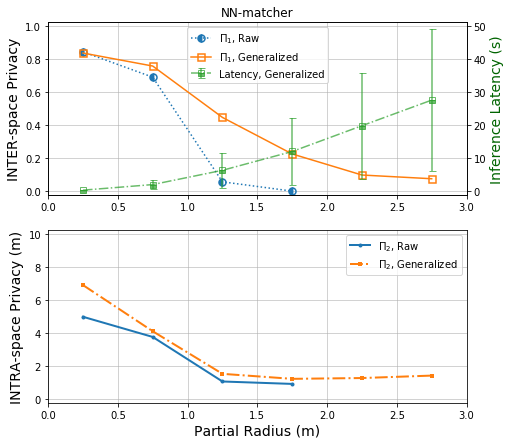

In [13]:
fig=plt.figure(figsize=(7.5, 7))

ARCoreNN = np.asarray(arcore_errors)

linewidth = 2.0
markersize = 2.0

ax2 = fig.add_subplot(212)#, sharex = ax1) 

ax2.grid(alpha = 0.7)
ax2.set_ylim(-0.25,10.25)
ax2.set_xlim(0,3)

ax2.set_ylabel("INTRA-space Privacy (m)", fontsize = 14);
ax2.set_xlabel("Partial Radius (m)", fontsize = 14);
#ax2.set_yticklabels(fontsize = 16)
#ax2.set_xticklabels(fontsize = 16)

#plt.minorticks_on()

ax2.plot(
    ARCoreNN[:,0],
    ARCoreNN[:,2],
    '-.s',
    linewidth = linewidth,
    fillstyle = 'none',
    mew = linewidth,markersize = markersize,
    label = "$\Pi_2$, Generalized"
)

ax2.legend(loc = "upper right", ncol = 1, fontsize = 10);#, bbox_to_anchor=(1.1, 1.5));

ax1 = fig.add_subplot(211, sharex = ax2) 

ax1.grid(alpha = 0.7)
ax1.set_ylim(-0.025,1.025)
ax1.set_xlim(0,3.0)
ax1.set_ylabel("INTER-space Privacy", fontsize = 14);
#ax1.set_xlabel("Partial Radius", fontsize = 14);

markersize = 7
linewidth = 1.5

p2 = ax1.plot(
    ARCoreNN[:,0],
    ARCoreNN[:,1],
    "-s",
    linewidth = linewidth,
    fillstyle = 'none',
    mew = linewidth,markersize = markersize,
    label = "$\Pi_1$, Generalized"
)

ax1.legend(loc = "upper right", ncol = 1, fontsize = 10);# bbox_to_anchor=(1.1, 1.5));
handles, labels = ax1.get_legend_handles_labels()

ax3 = ax1.twinx()
ax3.set_ylim(-1.25,51.25);
#ax1.set_xlim(0,2.0)
ax3.set_ylabel("Inference Latency (s)", fontsize = 14, color = 'darkgreen');

handles.append(p3), labels.append("Latency, Generalized")
ax1.legend(handles, labels,loc = 'upper center', fontsize = 10)
#ax1.set_xlabel("Partial Radius")

plt.title("NN-matcher")

#plt.savefig('plots/one-time-partials-spaces.png', format='png', dpi=300,bbox_inches = 'tight')


In [9]:
for object_name, t_d, t_k, t_d_c in arcore_descriptors:
    print(object_name)

[2, 'apartment', '2020.02.17.09.45.56']
[1, 'driveway', '2020.02.17.09.52.08']
[5, 'hallway', '2020.01.14.12.04.42']
[4, 'kitchen', '2020.01.14.13.58.34']
[0, 'reception', '2020.01.14.12.13.59']
[6, 'stairwell', '2020.01.14.14.11.52']
[3, 'workstation', '2020.01.14.11.17.09']
[7, 'workstation2', '2020.01.14.11.55.07']


In [7]:
def ARcore_NNMatcher(scores_pool, descriptors):

    t0 = time.time()

    errors = []

    score_map = []

    for obj_meta, diff_ratios, diff_indexs, diff_scores, local_keypoint_matches in scores_pool:

        #obj_meta = scores[0]
        #diff_ratios = scores[1]
        #diff_indexs = scores[2]

        diff_nn = diff_indexs[:,:,0]

        scores_per_object = []

        for c_o, c_d in enumerate(diff_ratios.T):
            nns = diff_nn[:,c_o]
            unq, unq_ind = np.unique(nns[np.argsort(c_d)], return_index=True)
            unique_scores = c_d[np.argsort(c_d)][unq_ind]

            scores_per_object.append([
                len(unique_scores),
                1-np.nanmean(unique_scores)
            ])

        scores_per_object = np.asarray(scores_per_object)
        weighted_scores = np.multiply(scores_per_object[:,1],scores_per_object[:,0]/len(diff_ratios))

        if np.any(np.isnan(weighted_scores)):
            nan_candidates = np.where(np.isnan(weighted_scores)==True)[0]
            print(obj_meta,object_labels[nan_candidates],len(diff_ratios))
            print(scores_per_object[nan_candidates,0],scores_per_object[nan_candidates,1])

        score_map.append(weighted_scores)

        # for ARCore, need to check descriptor match label
        obj_match = descriptors[np.argmax(weighted_scores)][0][0]

        if obj_meta[0] != obj_match: #!= i_o:
            errors.append([
                obj_meta[0], # object meta information
                1, #correct inter-space label or not
                np.nan, # distance from correct intra-spae label
                obj_match,
                np.argsort(weighted_scores)
                #np.argmax(weighted_scores)
            ])
        else: # Correct inter-space label; then, check intra-space label.

            #diff_scores = scores[3]
            #local_keypoint_matches = scores[4]

            best_keypointMatches = local_keypoint_matches[np.argmax(weighted_scores)]
            qry_kp = best_keypointMatches[1]
            ref_kp = best_keypointMatches[2]

            best_ref_kps, best_qry_kps  = get_best_kp_matches(
                ref_kp, qry_kp, 
                diff_ratios[:,np.argmax(weighted_scores)]
            )

            errors.append([
                obj_meta[0],
                0,
                LA.norm(np.nanmean(best_ref_kps[:,:3], axis = 0) - obj_meta[2][:3]),
                obj_match,
                np.argsort(weighted_scores)
                #np.argmax(weighted_scores)
            ])

    return np.asarray(errors)
